# Variational Autoencoder (VAE) in PyTorch

This notebook implements a **Variational Autoencoder (VAE)** using PyTorch and training it on the **MNIST dataset**.

## Step 1: Import Required Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Step 2: Load and Preprocess MNIST Dataset

In [3]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.23MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Step 3: Define the VAE Model

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2_mean = nn.Linear(400, 20)
        self.fc2_logvar = nn.Linear(400, 20)

        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc2_mean(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = 0.5 * torch.exp(logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Step 4: Define Loss Function and Optimizer

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Step 5: Train the VAE

In [6]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device).view(-1, 28*28)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 19098.2467
Epoch 2, Loss: 13149.7040
Epoch 3, Loss: 12274.6177
Epoch 4, Loss: 11827.8184
Epoch 5, Loss: 11552.1155
Epoch 6, Loss: 11366.0059
Epoch 7, Loss: 11222.4797
Epoch 8, Loss: 11123.4489
Epoch 9, Loss: 11042.4234
Epoch 10, Loss: 10975.1610


## Step 6: Visualize Reconstructions

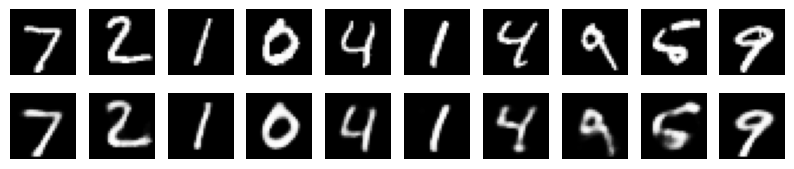

In [7]:
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device).view(-1, 28*28)
    recon_images, _, _ = model(test_images)

test_images = test_images.cpu().view(-1, 28, 28).numpy()
recon_images = recon_images.cpu().view(-1, 28, 28).numpy()

fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axes[0, i].imshow(test_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_images[i], cmap='gray')
    axes[1, i].axis('off')
plt.show()